In [1]:
%matplotlib inline

from collections import Counter
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np

mlp.style.use('fivethirtyeight')

# Neural Network - 手書き文字認識

以下の手順で進みます

- データの確認
- Neural Networkモデルの作成
- 作成したNeural Networkモデルを使った文字認識実験
- 作成したモデルを保存

参考：[ニューラルネットワークで数字を認識するWebアプリを作る](http://qiita.com/ginrou@github/items/07b52a8520efcaebce37)

## データの確認

訓練データが50,000件，テストデータが10,000件ある

- 入力 $X$: 28x28の画像を1次元の配列にしたもの
- 出力 $y$: 0~9の数字

In [2]:
mnist = np.load('data/mnist.npz')  # 事前にpre_processing.pyを実行しておくこと

X_train = mnist['X_train']
y_train = mnist['y_train']

X_test = mnist['X_test']
y_test = mnist['y_test']

In [3]:
# 訓練データのサイズ
X_train.shape

(50000, 784)

In [4]:
# テストデータのサイズ
X_test.shape

(10000, 784)

In [5]:
# データの中身はどうなっているのか？
print("Xの中身の例:")
print(X_train[25000][150:200])

print("yの中身の例:")
print(y_train[25000])

Xの中身の例:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.421875    0.90625     0.53515625  0.12890625  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]
yの中身の例:
3


描かれている数字: 5


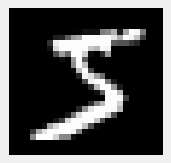

描かれている数字: 7


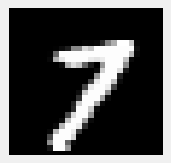

描かれている数字: 8


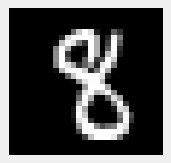

In [7]:
def draw_digit(data):
    size = 28
    X, Y = np.meshgrid(range(size), range(size))
    Z = data.reshape(size, size)
    Z = Z[::-1,:]

    plt.figure(figsize=(2.5, 2.5))
    
    plt.xlim(0, 27)
    plt.ylim(0, 27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    
    plt.show()

# 個々のデータを描画してみる
for i in [0, 40000, 49999]:
    print('描かれている数字: {0}'.format(y_train[i]))
    draw_digit(X_train[i])

## Neural Networkモデルの作成

実際にNeural Networkのモデルを作成してみる

- 活性化関数
- 情報の伝搬処理
- 重みの更新 ( ※時間的な問題で今回説明しません )
- 予測処理

### 活性化関数

In [8]:
# シグモイド関数

sigmoid = lambda x: 1. / (1. + np.exp(-x))

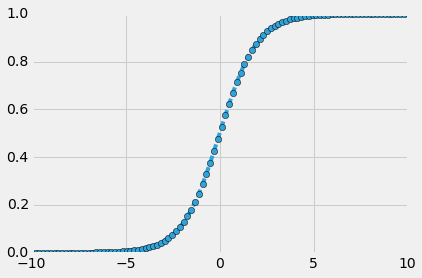

In [9]:
# 関数の形を描画してみる

x = np.linspace(-10, 10, 100)
y = [sigmoid(xi) for xi in x]

plt.plot(x, y, 'o--')

### 情報の伝播処理

ある階層 $l\ \ (l=1〜N)$ における情報の伝播は以下の式に基づき行われる

$${\bf u}^{(l+1)}={\bf W}^{(l+1)}{\bf z}^l+{\bf b}^{(l+1)}$$
$${\bf z}^{(l+1)}={\bf f}({\bf u}^{(l+1)})$$
$${\bf x}\equiv{\bf z}^{(1)}\ \ \ \ \ \ \ \ \ {\bf y}\equiv{\bf z}^{(L)}$$

In [10]:
def fire(x, hidden_weight, output_weight):
    z = np.vectorize(sigmoid)(hidden_weight.dot(np.r_[np.array([1]), x]))
    y = np.vectorize(sigmoid)(output_weight.dot(np.r_[np.array([1]), z]))
    return z, y

### 重みの更新 ( ※時間的な問題で今回説明しません )

In [11]:
def fit(x, t, hidden_weight, output_weight, learning_ratio=0.1):
    z, y = fire(x, hidden_weight, output_weight)
    dy = (y - t) * y * (1 - y)
    dz = (output_weight.T.dot(dy))[1:] * z * (1 - z)

    hidden_input = np.r_[np.array([1]), x]
    hidden_weight -= learning_ratio * dz.reshape(-1, 1) * hidden_input
    
    output_input = np.r_[np.array([1]), z]
    output_weight -= learning_ratio * dy.reshape(-1, 1) * output_input
 
    return hidden_weight, output_weight

### 予測処理

10次元のベクトルの要素のうち，最も値が大きいものを予測値として返す

In [12]:
def predicate(x, hidden_weight, output_weight):
    z, y = fire(x, hidden_weight, output_weight)
    return np.array(y).argmax()

## 作成したNeural Networkモデルを使った文字認識実験

作成したNeural Networkを使って文字認識の実験をしてみましょう

- 学習
- テスト

### 学習

- 入力層: 784次元 (28x28の画像データ)
- 出力層: 10次元 (0~9)
- 隠れ層: 324次元 ※値は適当 (18x18)

In [13]:
input_size = 784
output_size = 10
hidden_size = 324

# 重みを一様分布でおくと精度がめっちゃ下がるの面白かったので残しておく (50%位になる)
#hidden_weight = np.random.uniform(-1.0, 1.0, (hidden_size, input_size + 1))
#output_weight = np.random.uniform(-1.0, 1.0, (output_size, hidden_size + 1))

hidden_weight = 0.1 * (np.random.random_sample((hidden_size, input_size+1)) - 0.5)
output_weight = 0.1 * (np.random.random_sample((output_size, hidden_size+1)) - 0.5)

print(hidden_weight.shape)
print(output_weight.shape)

(324, 785)
(10, 325)


In [14]:
# 1-of-K 符号化処理
def to_formatted_array(y, output_size):
    formatted_y = np.zeros(output_size)
    formatted_y.put(y, 1)
    return formatted_y

In [15]:
# 学習データを利用して重みの更新処理を行う

train_size = X_train.shape[0]
for i in range(train_size):
    x = X_train[i]
    y = to_formatted_array(y_train[i], output_size)

    hidden_weight, output_weight = fit(x, y, hidden_weight, output_weight)

最終的に得られる `hidden_weight` と `output_weight` が学習結果

### テスト

実際にどの程度の精度で予測が行えるのかをテストする

In [16]:
digit2ok = Counter()
digit2ng = Counter()

test_size = X_test.shape[0]
for i in range(test_size):
    x = X_test[i]
    y = y_test[i]

    pred = predicate(x, hidden_weight, output_weight)
    if int(y) == int(pred):
        digit2ok[y] += 1
    else:
        digit2ng[y] += 1

In [17]:
sum_all = sum(digit2ok.values())
print("{0:05d} / {1:05d} = {2:3.2f}%".format(sum_all, test_size, 100. * sum_all / test_size))
print("\n---- 内訳 ----\n")
for digit in sorted(digit2ok.keys()):
    sum_digit = digit2ok[digit] + digit2ng[digit]
    print("{0}: {1:05d} / {2:05d} = {3:3.2f}%".format(digit, digit2ok[digit], sum_digit, 100. * digit2ok[digit] / sum_digit))

09291 / 10000 = 92.91%

---- 内訳 ----

0: 00962 / 00980 = 98.16%
1: 01111 / 01135 = 97.89%
2: 00935 / 01032 = 90.60%
3: 00944 / 01010 = 93.47%
4: 00889 / 00982 = 90.53%
5: 00772 / 00892 = 86.55%
6: 00900 / 00958 = 93.95%
7: 00959 / 01028 = 93.29%
8: 00882 / 00974 = 90.55%
9: 00937 / 01009 = 92.86%


文字識別結果を描画してみる

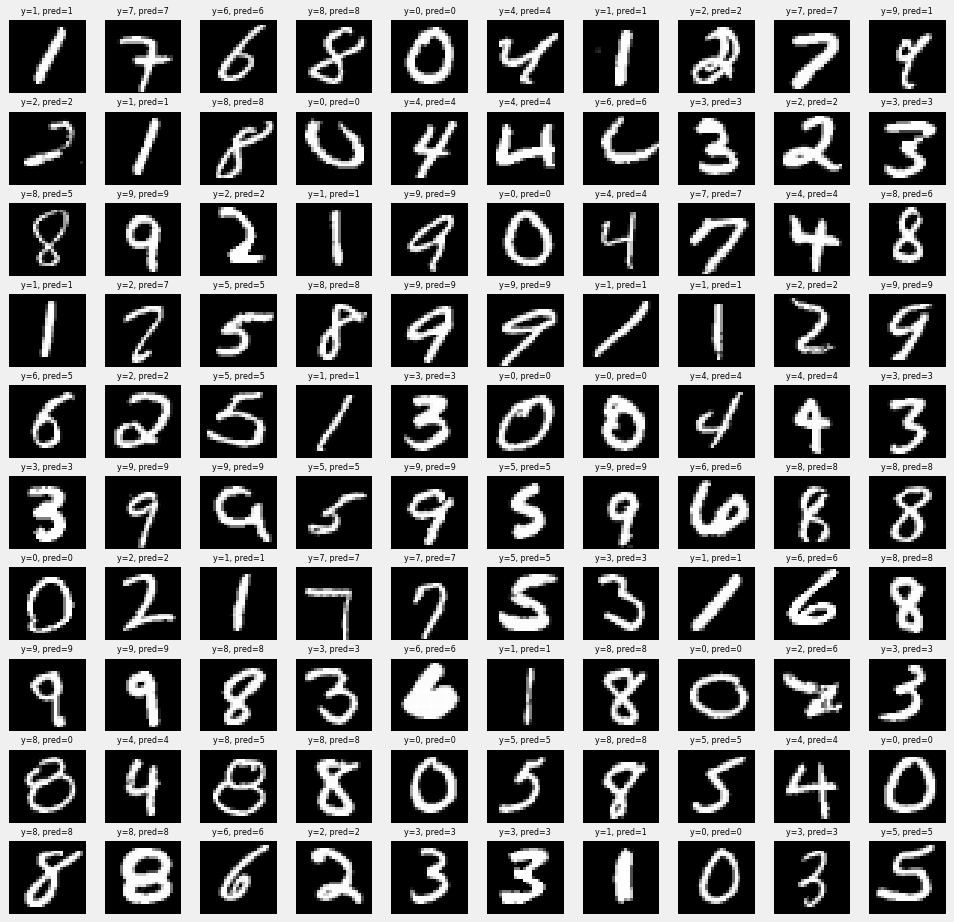

In [18]:
def draw_result(X, y, pred, cnt):
    size = 28
    Z = X.reshape(size, size)
    Z = Z[::-1,:]
    
    plt.subplot(10, 10, cnt)
    plt.xlim(0, size - 1)
    plt.ylim(0, size - 1)
    plt.pcolor(Z)
    plt.title("y={0}, pred={1}".format(y, pred), size=8)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(15, 15))
for cnt, idx in enumerate(np.random.permutation(test_size)[:100]):
    x = X_test[idx]
    pred = predicate(x, hidden_weight, output_weight)
    draw_result(X_test[idx], y_test[idx], pred, cnt+1)
plt.show()

隠れ層の重みを描画してみる

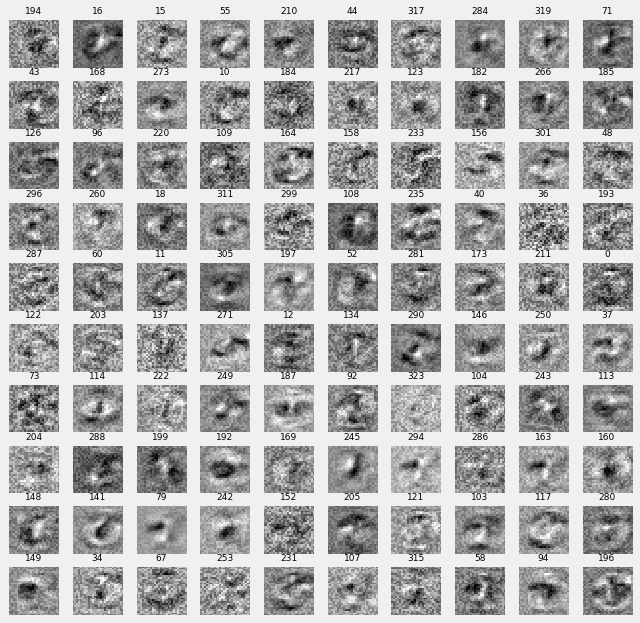

In [19]:
def draw_hidden(data, cnt, idx):
    size = 28
    Z = data.reshape(size, size)
    Z = Z[::-1,:]
    
    plt.subplot(10, 10, cnt)
    plt.xlim(0, size - 1)
    plt.ylim(0, size - 1)
    plt.pcolor(Z)
    plt.title("{0}".format(idx), size=9)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(10, 10))
for cnt, idx in enumerate(np.random.permutation(hidden_size)[:100]):
    draw_hidden(hidden_weight[idx][:-1], cnt+1, idx)
plt.show()

出力層の重みを描画してみる

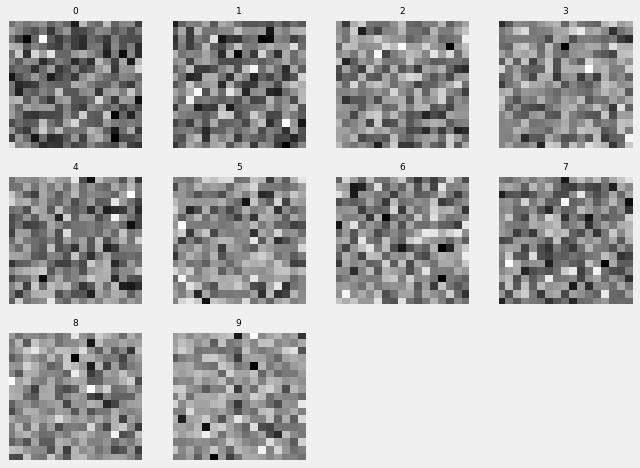

In [20]:
def draw_output(data, i):
    size = 18
    Z = data.reshape(size, size)
    Z = Z[::-1,:]
    plt.subplot(4, 4, i + 1)
    
    plt.xlim(0, size - 1)
    plt.ylim(0, size - 1)
    plt.pcolor(Z)
    plt.title("{0}".format(i), size=9)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(10, 10))
for i in range(output_size):
    draw_output(output_weight[i][:-1], i)
plt.show()

## 作成したモデルを保存

In [21]:
np.savez('data/neural_network', hidden=hidden_weight, output=output_weight)